# Visual Odometry for Localization in Autonomous Driving

### Feature Detection, Description, Matching and Trajectory Generation with a comparison of transformation reconstruction methods for optimal path estimates



This project estimates an autonomous vehicle trajectory using a sequence of images taken with a monocular camera mounted on a vehicle. The images are from a CARLA autonomous driving simulator that include both RGB and grayscale versions. Depth maps for each image are also utilized.

Reconstruction of the transform between consecutive images consisting of a rotation matrix and translation vector necessary for the trajectory point calculations is made using three different methods: EMD (Essential Matrix Decomposition), PnP, (Perspective-n-Point), and PnP-RANSAC. 

A comparison of the trajectory results using EMD, PnP, and PnP-RANSAC
with both distance filtered and unflitered feature matches between images is done with visual plots of the trajectories.



**The basic project outline:**

- Explore the image set, depth maps, and intrinsic camera parameters
- Compare RGB and grayscale images
- Preprocess images with gaussian filtering
- Extract  features from the sequence of images
- Match features between consecutive images
- Create distance filtered and unfiltered matched pair sets for calculations
- Use matched feature pairs to estimate camera motion in 3D camera coordinate frame between images
- Build the trajectory paths using three transformation types: EMD, PnP, and PnP-RANSAC
- Plot out results for EMD, PnP, and PnP-RANSAC for both filtered and unflitered feature matching
- Compare results to find the best method
- Suggest possible variations and enhancements to improve the trajectories




In [2]:
#mk
#v0.18


import numpy as np
import cv2
from matplotlib import pyplot as plt
from m2bk import *

import numpy.linalg as nla

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)
#np.set_printoptions(threshold=np.nan)

print()
print("Open CV version: "+ str(cv2.__version__))
print()

    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Open CV version: 3.4.8



## 1 - Loading and Visualizing the Data
Instantiate a dataset handler class to read and iterate through samples taken from the CARLA simulator

In [3]:
dataset_handler = DatasetHandler()

The dataset handler loads 52 data frames. Each frame contains an RGB image, a grayscale version and a depth map. The camera calibration matrix K is also provided.

When the dataset handler object is created, all the frames are read and loaded as part of the initialization. The frame content can be accessed by using the attributes for `images`, (grayscale) `images_rgb`, (RGB) and`depth_maps`  of the dataset handler object along with the index of the requested frame. The intrinsic matrix K is accessed as `k`.

Maximum depth distance is 1000 m (1km) This corresponds to the simulator depth map value ranges.  This value of depth indicates that the selected pixel is at least 1000m (1km) away from the camera. The exact distance beyond that is unknown. 

This outer limit range will be used as a upper bound to assertain which points are valid enough to use in some of the tranformation recovery calculations.


### 1.1 - Visualize RGB and Grayscale image frames 


image dimensions: (960, 1280)



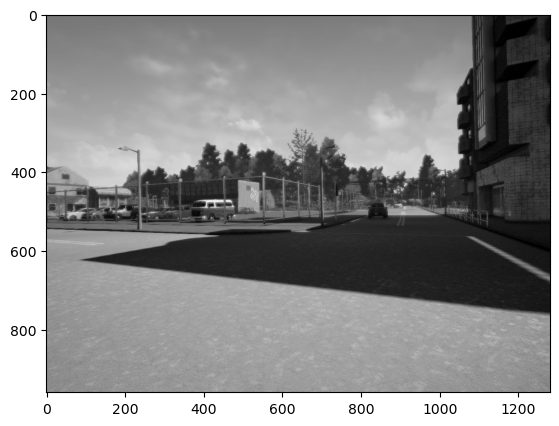

In [4]:
#
# take a look at a grayscale image
#

image = dataset_handler.images[0]

print();print("image dimensions: "+str(image.shape));print()

#plt.figure(figsize=(8, 6), dpi=100)
plt.figure(figsize=(7, 5), dpi=100)
plt.imshow(image, cmap='gray')

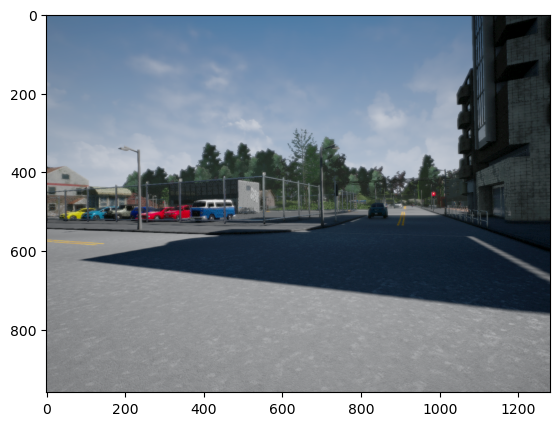

In [5]:
#
# take a look at the RGB color version
#

image_rgb = dataset_handler.images_rgb[0]


#plt.figure(figsize=(8, 6), dpi=100)
plt.figure(figsize=(7, 5), dpi=100)

plt.imshow(image_rgb)

###  1.2 - Denoise images

The denoising function assumes the noise is zero mean uncorreleated gaussian noise

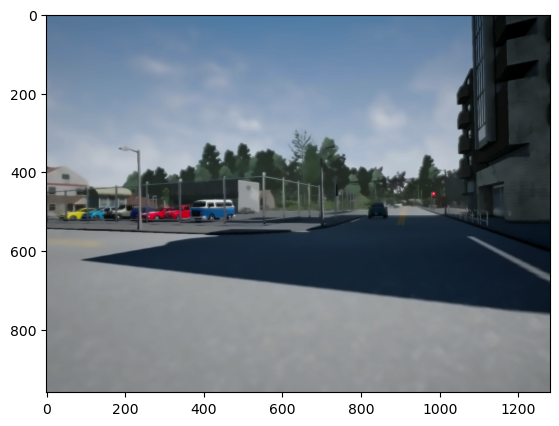

In [6]:
# look at gaussian denoised RGB
# cv denoising function assumes noise is zero mean uncorreleated gaussian noise

image_rgb = dataset_handler.images_rgb[0]
img_rgb_denoised=cv2.fastNlMeansDenoisingColored(image_rgb,None,10,10,7,21)


#plt.figure(figsize=(8, 6), dpi=100)
plt.figure(figsize=(7, 5), dpi=100)
plt.imshow(img_rgb_denoised)


### 1.3 - Compare raw and denoised  object images

function uses a gaussian filter that assumes the images have 
zero mean uncorellated gausian noise

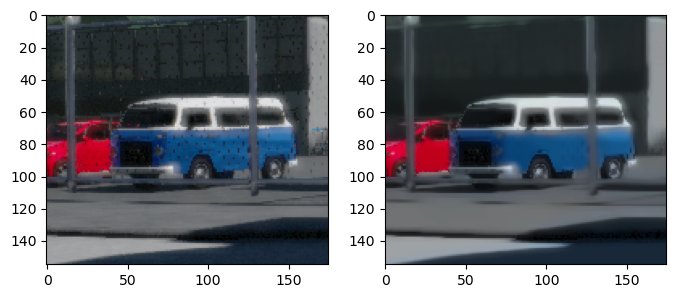

In [7]:
#
# compare original image with denoised version for a VW van in the scene
#

img = dataset_handler.images_rgb[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)

dno = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

ymin=420;ymax=575
xmin=325;xmax=500

bbox_img=img[ymin:ymax,xmin:xmax] 
bbox_dno=dno[ymin:ymax,xmin:xmax] 

plt.subplot(121),plt.imshow(bbox_img)
plt.subplot(122),plt.imshow(bbox_dno)
plt.show()



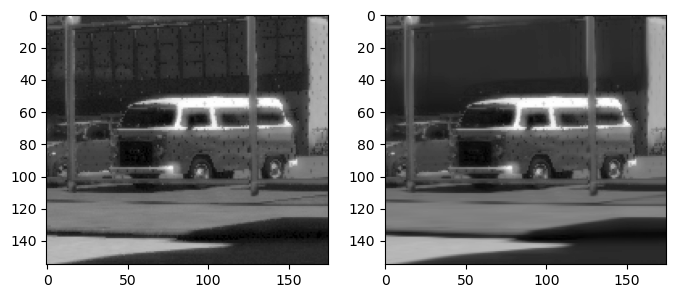

In [8]:
#
# and grayscale
# compare original image with denoised version for a VW van in the scene
# if using grayscale for trajectory test parameters to get best result
#

img = dataset_handler.images[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)

dno = cv2.fastNlMeansDenoising(image,31, 7, 21)

ymin=420;ymax=575
xmin=325;xmax=500

bbox_img=img[ymin:ymax,xmin:xmax] 
bbox_dno=dno[ymin:ymax,xmin:xmax] 

plt.subplot(121),plt.imshow(bbox_img,cmap='gray')
plt.subplot(122),plt.imshow(bbox_dno,cmap='gray')
plt.show()



### 1.4 - Depth map

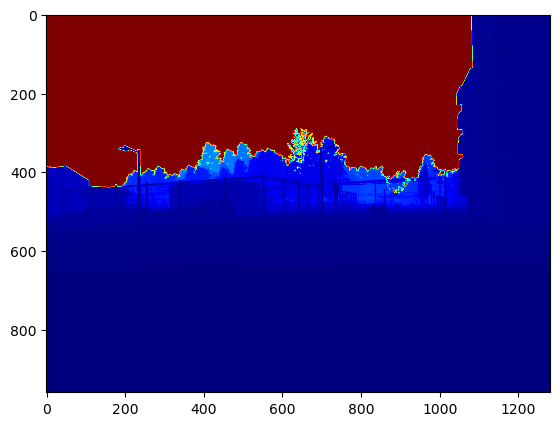

In [9]:
#
# take a look at depth map
#

i = 0 #select index for image

depth = dataset_handler.depth_maps[i]


#plt.figure(figsize=(8, 6), dpi=100)
plt.figure(figsize=(7, 5), dpi=100)
plt.imshow(depth, cmap='jet')

In [10]:
# 
# get an brief idea of distances provided by the depth map
#

print();print("Depth map shape: {0}".format(depth.shape));print()

v, u = depth.shape
depth_val = depth[v-1, u-1]

print("Depth value of bottom-right-most pixel of depth map {0} is: {1:0.3f} m)".format(i, depth_val))
print()
print("An outer limit distance in the sky area")
depth_val = depth[0, 0]
print("Depth value of Upper-Left-most pixel of depth map {0} is: {1:0.3f} m)".format(i, depth_val))
print()


Depth map shape: (960, 1280)

Depth value of bottom-right-most pixel of depth map 0 is: 1.862 m)

An outer limit distance in the sky area
Depth value of Upper-Left-most pixel of depth map 0 is: 1000.000 m)



### 1.5 - Intrinsic camera calibration matrix

In [11]:
#
# take a look at intrinsic camera calibration matrix
#
K=dataset_handler.k
print();print("intrinsic matrix K: ");print()
print(K)
print()


intrinsic matrix K: 

[[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]



In [13]:
#
# check number of frames in the dataset
#
print("Number of frames in dataset: "+str(dataset_handler.num_frames));print()

Number of frames in dataset: 52



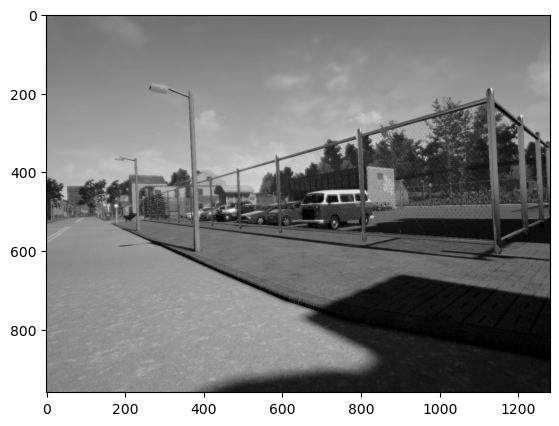

In [14]:
#
# another location in images sequence
#
i = 30
image = dataset_handler.images[i]


#plt.figure(figsize=(8, 6), dpi=100)
plt.figure(figsize=(7, 5), dpi=100)
plt.imshow(image, cmap='gray')

## 2 - Feature Extraction

### 2.1 - Extracting Features from an Image



This function can process either an RGB image or a grayscale image. The denoise flag can be set to use gaussian denoise on the image. eg. denoise=True or denoise=False 

Modify the parameters to acheive different or better results.

The function can be modified to extract features with different descriptors such as SIFT, ORB, SURF and BRIEF. This also depends on the version of opencv as to which ones are implemented.

Some useful references: 

The structure of the keypoint descriptor object:
[OpenCV: Keypoint Class Description](https://docs.opencv.org/3.4.3/d2/d29/classcv_1_1KeyPoint.html)

Features and Descriptors:
[OpenCV:Feature Detection and Description](https://docs.opencv.org/3.4.3/db/d27/tutorial_py_table_of_contents_feature2d.html)

Image denoising:
[OpenCV:Denoising](https://docs.opencv.org/master/d1/d79/group__photo__denoise.html)

It is also possible to use detectors such as Harris corners or FAST and pairing them with a descriptor. 

 

In [15]:
def extract_features(image,denoise=None):
    """
    Find keypoints and descriptors for the image
    set flag denoise to run gaussian denoiser
    Returns:
    kps -- list of the extracted keypoints (features) in an image
    desc -- list of the keypoint descriptors in an image
        
    """
    #img = cv2.imread(image,0)
    
    # gausian denoise image first if flag set
    # cv denoising functions assumes noise is zero mean uncorreleated gaussian noise
    
    if denoise == True:

        # ck if RGB or grayscale
        if (len(image.shape) == 3 and image.shape[2] == 3):
            image = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)
        else:
            image = cv2.fastNlMeansDenoising(image,31, 7, 21)

    # Initiate ORB detector

    orb = cv2.ORB_create(nfeatures=1500)#, scoreType=cv2.ORB_FAST_SCORE)
    
    kp, desc = orb.detectAndCompute(image,None)

   # onlyif cv2 contrib version is 3.4.2.16 or below! 
   # surf = cv2.xfeatures2d.SURF_create()
   # kp = surf.detect(image, None)
   # kp, desc = surf.compute(image, kp)
    
    # sift also not included
    #sift = cv.SIFT_create()
    #kp, desc = sift.detectAndCompute(gray,None)
    
    return kp, desc


In [16]:
i = 0
# use grayscale
image = dataset_handler.images[i]

#print(image.shape)
#plt.imshow(image)#,cmap='gray')

# 

kps, desc = extract_features(image,denoise=True)

print()
print("Number of features detected in frame {0}: {1}\n".format(i, len(kps)))

print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kps[0].pt)))
print()



Number of features detected in frame 0: 1500

Coordinates of the first keypoint in frame 0: (344.0, 394.0)



### 2.2 - Visualize features


In [17]:
def visualize_features(image, kps, enhanced=None):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kps -- list of the image keypoints

    Returns:
    """
    if enhanced == None or enhanced == False:
        
        display = cv2.drawKeypoints(image, kps, None, color=(0,255,127), flags=0)
    else:
        display = cv2.drawKeypoints(image, kps, None, color=(0,255,127), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(display)
 


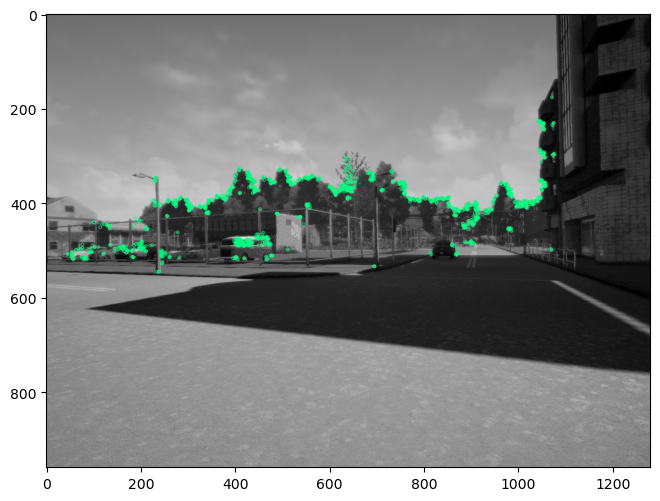

In [18]:
# visualize feature descriptor locations

i = 0

image = dataset_handler.images_rgb[i]

image = dataset_handler.images[i]

visualize_features(image, kps,enhanced=False)


### 2.3 - Extract features from all images in the dataset

Extract features for all images in the dataset. 

Function has a progress indicator. RGB images can be slower computationally.


In [19]:
def extract_features_for_dataset(images,extract_features_function,denoise=None):
    
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function that finds
        features (keypoints and descriptors) for an image
    denoise -- flag to use denoise or not

    Returns:
    kp_list -- a list of keypoints for each image in images
    desc_list -- a list of descriptors for each image in images
    
    """

    kp_list = []
    desc_list = []
    
    print();print("Progress... ",end=' ')
    
    for i in range(len(images)):
        #
        print(str(i)+" ",end=' ')
        kp,desc = extract_features_function(images[i],denoise)
        kp_list.append(kp)
        desc_list.append(desc)
    
    print();print()
    
    return kp_list, desc_list

In [20]:

#images = dataset_handler.images_rgb ######### test W/ RGB & gaussian denoise

images = dataset_handler.images # just grayscale images

# can set denoise gaussian if wanted
kp_list, desc_list = extract_features_for_dataset(images,\
                            extract_features_function=extract_features,\
                            denoise=False)

i = 0
print("Number of features detected in frame {0}: {1}".format(i, len(kp_list[i])))
print("Coordinates of the first keypoint in frame {0}: {1}\n".format(i, str(kp_list[i][0].pt)))

# Remember that the length of the returned by dataset_handler lists should be the same as the length of the image array
print("Length of images array: {0}".format(len(images)))
print()
print("Check to make sure everything is somewhat intact so far")
print("If true then our \"ducks are in a row\"")
print();print("Array length check OK? ",end=' ')
print(((len(kp_list) == len(desc_list) == len(images)) == True) )




Progress...  0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  

Number of features detected in frame 0: 1500
Coordinates of the first keypoint in frame 0: (1004.0, 408.0)

Length of images array: 52

Check to make sure everything is somewhat intact so far
If true then our "ducks are in a row"

Array length check OK?  True


## 3 - Feature Matching
 
Match the features between consecutive image pairs. 


### 3.1 - Matching features from a pair of consecutive image frames

This can be implemented with various algorithms. For instance: Brute Force Matching or FLANN based matching and others.

Some very basic match filtering is provided. This is done by thresholding the distance between the best matches. 

A comparison of the filtered and unfiltered results can be made in the final section of this project.

The results can be used to improve the overall trajectory estimation results.

The number best matches to be returned by the matcher and other runtime parameters can also be specified in the code.


In [21]:
def match_features(des1, des2):
    
    """
    Match features from two images

    Arguments:
    desc1 -- list of the keypoint descriptors in the first image
    desc2 -- list of the keypoint descriptors in the second image

    Returns:
    matches -- list of matched features from two images
    # Each match[i] is k or less matches for the same query descriptor
    ie. consecutive images or an image with previous image
    """
    
    # distance function set to use with ORB
    # create BFMatcher object
    # bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors.
    # match = bf.match(des1,des2)
    
    # FLANN parameters
        
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm = FLANN_INDEX_LSH,
                        table_number = 6,
                        key_size = 12,
                        multi_probe_level = 1)
    
    search_params = dict(checks = 50)
    
    # create FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # get matches 
    match = flann.knnMatch(des1, des2, k=2)
    

    return match

In [22]:
i = 0
desc1 = desc_list[i]
desc2 = desc_list[i+1]

match = match_features(desc1, desc2)
print()
print("Number of features matched between frames {0} and {1}: {2}".format(i, i+1, len(match)))
print()


Number of features matched between frames 0 and 1: 1500




### 3.2 - Filtering by distance for matched features between two images

Distance filtering by thresholding the distance between the best matches from a pair of matched features between two images

<br>





In [23]:
def filter_matches_by_distance(match, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """   
 
    filtered_matches = []
    
    for m, n in match:
        if m.distance < dist_threshold * n.distance:
            filtered_matches.append(m)
            
    return filtered_matches



In [24]:

i = 0

desc1 = desc_list[i]
desc2 = desc_list[i+1]
match = match_features(desc1, desc2)

dist_threshold = 0.6
filtered_match = filter_matches_by_distance(match, dist_threshold)

print()
print("Number of features matched between frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_match)))
print()



Number of features matched between frames 0 and 1 after filtering by distance: 580



In [25]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
        
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None)
#     image_matches = cv2.drawMatchesKnn(image1, kp1, image2, kp2, match, None)
    
     #plt.figure(figsize=(16, 6), dpi=100)
    plt.figure(figsize=(16*2, 6*2), dpi=100)
    
    plt.imshow(image_matches)  

    #image_matches = cv2.drawMatches(image1,kp1,image2,kp2,match,None)
   
    #plt.imshow(image_matches)

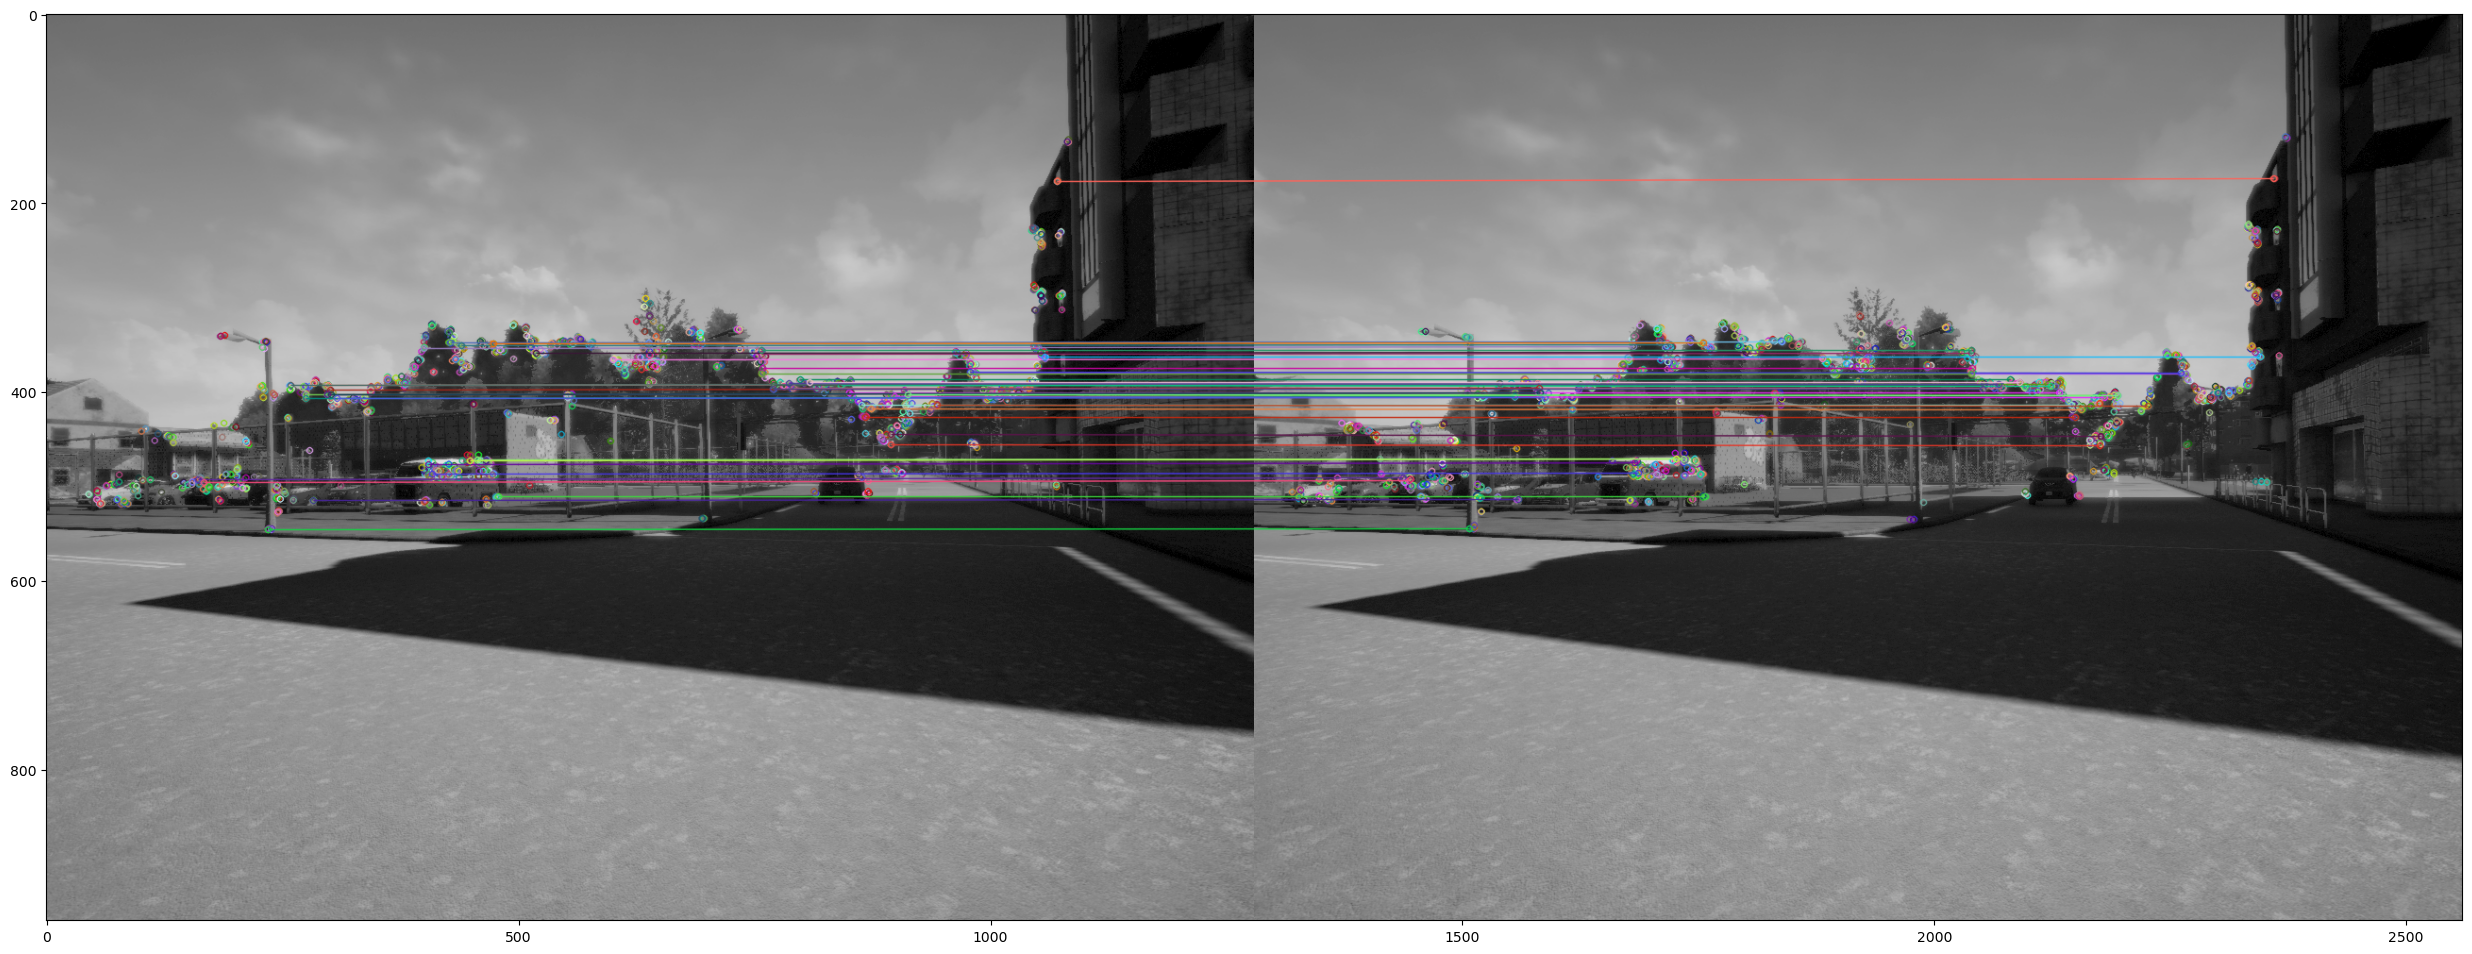

In [26]:

# Visualize n first matches, set n to None to view all matches
# set use_iltering flag True if using match filtering and set distancing threshold

n = 50

use_filtering = True
dist_threshold = 0.5

i = 0

image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

desc1 = desc_list[i]
desc2 = desc_list[i+1]

match = match_features(desc1, desc2)

if use_filtering:
    
     match = filter_matches_by_distance(match, dist_threshold)

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])    


### 3.3 - Matching features between each consecutive image pair in the entire dataset

Both unfiltered matches and filtered results are kept for comparison and evaluation


In [27]:
def match_features_for_dataset(desc_list, match_features_function):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    desc_list -- a list of descriptors for each image in the dataset
    match_features_function -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each consecutive image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
               
    """
    matches = []
    

    for i in range(len(desc_list)-1):
        matches.append(match_features_function(desc_list[i],desc_list[i+1]))
        
    
    return matches


In [28]:
matches = match_features_for_dataset(desc_list, match_features_function=match_features)

i = 0
print()
print("Number of features matched between frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))
print()


Number of features matched between frames 0 and 1: 1500



In [29]:
def filter_matches_for_dataset(filter_matches_function, matches, dist_threshold):
    """
    Filter matched features by distance for each consecutive image pairs in the dataset

    Arguments:
        filter_matches__function -- a function that filters matched features from two images by distance between the best matches
        matches -- list of matches for each consecutive image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
        dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
        filtered_matches -- list of filtered matches for consecutive image pairs in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    
    filtered_matches = []
    
    for match in matches:
        filtered = filter_matches_function(match, dist_threshold)
        filtered_matches.append(filtered)
    
    return filtered_matches


In [30]:

matches = match_features_for_dataset(desc_list, match_features_function=match_features)

dist_threshold = 0.5

i = 0

filtered_matches=filter_matches_for_dataset(filter_matches_by_distance, matches, dist_threshold)

print()
print("Number of matches (unfiltered) between frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

#print(type(filtered_matches))
print()
print("Number of filtered matches between frames {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))


# dont, keep both for later!

#if (use_filtering == True):
#    matches = filtered_matches
    
print()



Number of matches (unfiltered) between frames 0 and 1: 1500

Number of filtered matches between frames 0 and 1: 418



## 4 - Trajectory Estimation



### 4.1 - Estimating camera motion between a pair of images

Implements camera motion estimation from a pair of images. A choice of reconstruction methods
using EMD (Essential Matrix Decomposition), PnP, (Perspective-n-Point), or PnP-RANSAC can be set 
in the function call.
 

Some useful background references are:

EMD (Essential Matrix Decomposition)  [Wikipedia: Determining R and t from E](https://en.wikipedia.org/wiki/Essential_matrix).


Transforms and relation between 3D world and 2D coordinate systems 
[OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html)


In [31]:
def estimate_motion(matched_features, kp1, kp2, K, depth_map=None, algo_type=None):
    """
    Estimate camera motion from a pair of consecutive image frames

    Arguments:
    matched_features -- list of matched features from a pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    K -- camera calibration matrix 
    
    Optional arguments:
    depth_map -- a depth map (singular) of the first frame in match (dont need for EMD)
    
    Returns:
    rmat -- recovered [3x3] rotation numpy matrix
    tvec -- recovered [3x1] translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """

    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    
    camera_points = [] # for PnP
    
    if (algo_type is None): # set default
        algo_type='pnp_ransac'
       
    ###
    
    for match in matched_features:
        
        query_idx = match.queryIdx
        train_idx = match.trainIdx
        
        # query and train order corresponds to matcher call
        
        # get image pixel keypoint coords 
        u1, v1 = kp1[query_idx].pt #np.uint(kp1[query_idx].pt)
        u2, v2 = kp2[train_idx].pt #np.uint(kp2[train_idx].pt)
        
        # depth is scale of features
        depth = depth_map[int(v1), int(u1)] # (v,u) for array indexing
        
        # keep odometry earthbound 
        if (depth < 1000): # 1000 is outermost distances or beyond
            image1_points.append([u1, v1])
            image2_points.append([u2, v2])
            
            ### PnP-RANSAC
            if (algo_type == 'pnp_ransac' or algo_type == 'pnp'):
               # transform pixel coords to camera frame coords
                p_camera = nla.inv(K) @ (depth * np.array([u1, v1, 1]))
                camera_points.append(p_camera)

    # as arrays
    img1_points = np.array(image1_points)
    img2_points = np.array(image2_points)
    
    ### PnP-RANSAC
    if (algo_type == 'pnp_ransac'):  
        objectpoints=np.vstack(camera_points)
        imagepoints=img2_points
        _, rvec, t, _ = cv2.solvePnPRansac(objectpoints,imagepoints,K,None)
        R, _ = cv2.Rodrigues(rvec)
        
    ### PnP
    if (algo_type == 'pnp'):
        objectpoints=np.vstack(camera_points)
        imagepoints=img2_points
        distCoeffs = np.zeros((8, 1), dtype='float32')
        _, rvec, t = cv2.solvePnP(objectpoints,imagepoints,K, distCoeffs)
        #_, rvec, t, _ = cv2.solvePnPRansac(objectpoints,imagepoints,K,None)
        R, _ = cv2.Rodrigues(rvec)
        

    ### EMD
    if (algo_type == 'emd'):
        E, mask = cv2.findEssentialMat(img1_points, img2_points, K)
        _, R, t, mask = cv2.recoverPose(E, img1_points, img2_points, K)
    

    return R, t, image1_points, image2_points


### 4.2 - Examples of reconstructed transforms between image frames 

Readouts of the transforms T=[R|t] consisting of R the rotation matrix and t the translation vector for given image pair
for each of the three transform recovery methods


In [33]:

matches = match_features_for_dataset(desc_list, match_features_function=match_features)

filtered_matches=filter_matches_for_dataset(filter_matches_by_distance, matches, dist_threshold)

use_filtering = True
dist_threshold = 0.5

#print();print("type matches ",type(matches));print()

i=0
#match = matches[i]
match = filtered_matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
K = dataset_handler.k
depth = dataset_handler.depth_maps[i]

print();print("Running default...");print()
rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, K, depth_map=depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

print();print("Running EMD...");print()
rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, K, depth_map=depth,\
                                                           algo_type='emd')
print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

print();print("Running PnP...");print()
rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, K, depth_map=depth,\
                                                       algo_type='pnp')
print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

print();print("Running PnP RANSAC...");print()
rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, K, depth_map=depth,\
                                                           algo_type='pnp_ransac')
print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))




Running default...

Estimated rotation:
 [[ 9.99983491e-01 -5.64928395e-03  1.04995119e-03]
 [ 5.64992273e-03  9.99983855e-01 -6.06429292e-04]
 [-1.04650835e-03  6.12351424e-04  9.99999265e-01]]
Estimated translation:
 [[ 0.0126102 ]
 [ 0.00286396]
 [-0.29611671]]

Running EMD...

Estimated rotation:
 [[ 9.99983362e-01 -5.67837626e-03  1.01576375e-03]
 [ 5.67886990e-03  9.99983758e-01 -4.83758089e-04]
 [-1.01300029e-03  4.89518430e-04  9.99999367e-01]]
Estimated translation:
 [[ 0.21419716]
 [-0.03670181]
 [-0.97610069]]

Running PnP...

Estimated rotation:
 [[ 9.99983491e-01 -5.64928490e-03  1.04995069e-03]
 [ 5.64992369e-03  9.99983855e-01 -6.06430598e-04]
 [-1.04650784e-03  6.12352728e-04  9.99999265e-01]]
Estimated translation:
 [[ 0.01261019]
 [ 0.002864  ]
 [-0.2961167 ]]

Running PnP RANSAC...

Estimated rotation:
 [[ 9.99983491e-01 -5.64928395e-03  1.04995119e-03]
 [ 5.64992273e-03  9.99983855e-01 -6.06429292e-04]
 [-1.04650835e-03  6.12351424e-04  9.99999265e-01]]
Estimated t

### 4.3 - Camera movement visualization



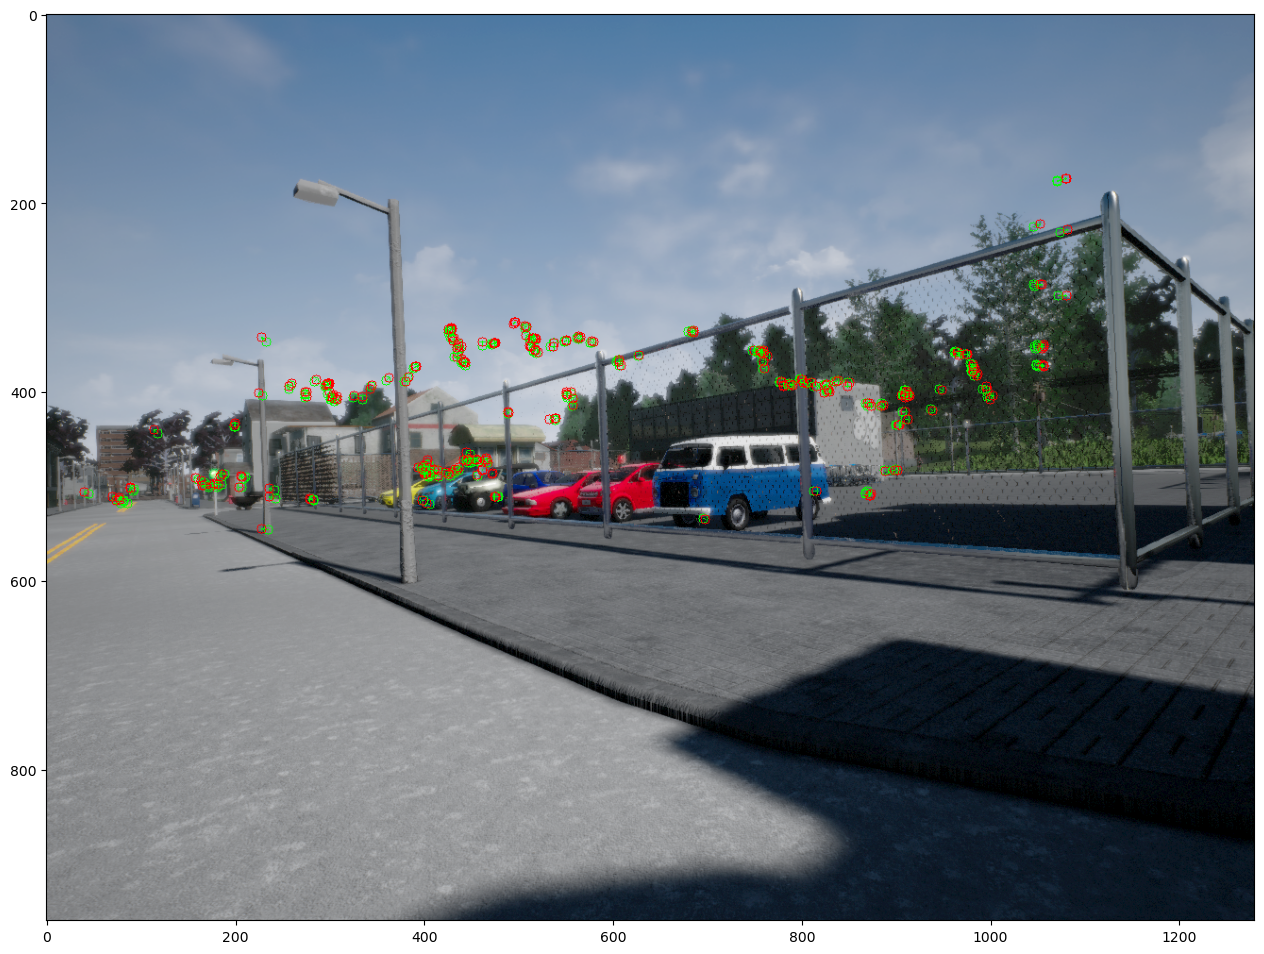

In [34]:
# set the frame to look at

i=30

image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i + 1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

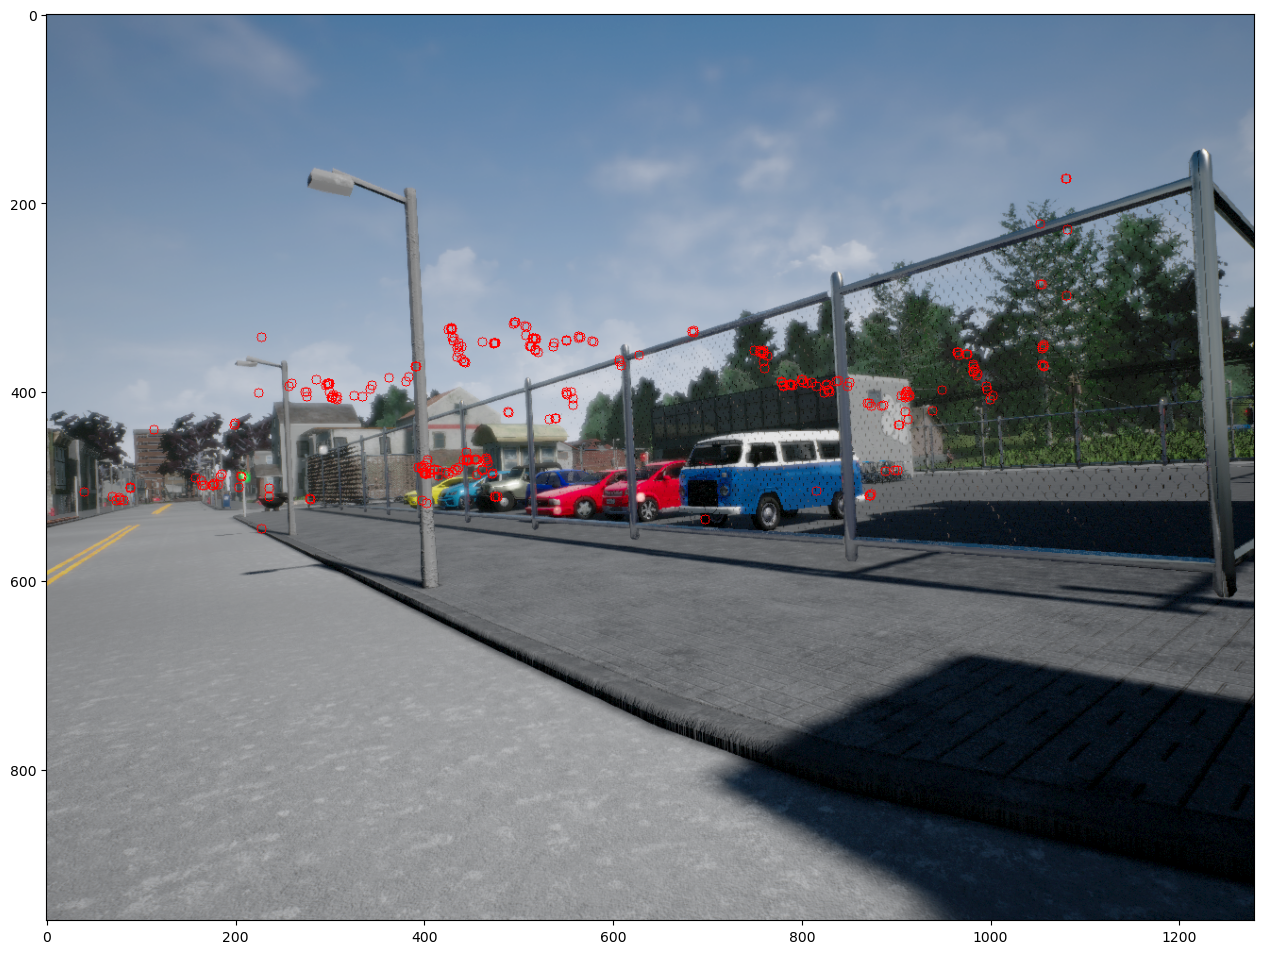

In [35]:
image_move = visualize_camera_movement(image1, image1_points, image2, image2_points, is_show_img_after_move=True)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)
# These visualizations might be helpful for understanding the quality of image points selected for the camera motion estimation

### 4.4 - Camera trajectory estimation

The trajectory calculation function has a runtime mode that can be set. 

The current choices are: 

EMD (Essential Matrix Decomposition) :   mode='emd'

PnP (plain Point in Perspective) :   mode='pnp'

PnP RANSAC (PnP that also runs an implementation of the RANSAC algorithm to
filter outliers for more accurate trajectory results) :   mode='pnp_ransac'


In [36]:
def estimate_trajectory(estimate_motion, matches, kp_list, K, depth_maps=[],mode=None):
    """
    Estimate the camera trajectory from the entire set of consecutive image pairs

    Arguments:
    
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    desc_list -- a list of keypoints for each image in the dataset
    K -- camera calibration matrix 
    
    Optional arguments:
    
    depth_maps -- a list of all depth maps for each frame in the image data set
    
    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is x coordinate of the i-th location
                  trajectory[:, i][1] - is y coordinate of the i-th location
                  trajectory[:, i][2] - is z coordinate of the i-th location
                  
                  the origin of the trajectory cordinate system is located
                  at the camera position when the first image was taken
                  The first camera location (index = 0) is given
                  at the initialization of this function

    """
    #trajectory = np.zeros((3, 1))

    trajectory = [np.array([0, 0, 0])] #init list
    
    
    T = np.eye(4) # [4x4] initial transform T to start trajectory
    
    for i in range(len(matches)):
        
        match = matches[i]
        
        kp1 = kp_list[i]
        kp2 = kp_list[i+1]
        
        depth = depth_maps[i]
        
        #[3x3],[3x1]
        
        R, t, image1_points, image2_points = estimate_motion(match, kp1, kp2, K, depth,algo_type=mode)

        # construct new camera transform from current match 
        # T = [R|t] expressed in homogeneous form
        
        Rt=np.hstack([R,t])   
        Tn=np.vstack([Rt,np.array([0,0,0,1])]) # [4x4]
        
        Tn_inv=nla.inv(Tn)
        
        # R close to identity since camera not rotating (hopefully)
        # with respect to itself between images, translation changes
        
        T = T @ Tn_inv 
        
        tv = T[:3,3] 
        
        trajectory.append(tv)
    
    
    trajectory = np.array(trajectory).T  # format list for output

    return trajectory
        

### 4.5 - Trajectory starting positions for each transform recovery method



In [37]:
depth_maps = dataset_handler.depth_maps

use_filtering=True

if (use_filtering == True):
    matches = filtered_matches

print()

# check origin
i=0
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, K, depth_maps=depth_maps)
print("Check origin (x,y,z) location");print()
print("Default Mode")
print("Camera location at point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

i = 1 # SET TO 0 to double check origin setting!

# default
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, K, depth_maps=depth_maps)
print("Default Mode")
print("Camera location at point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# emd
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, K, depth_maps=depth_maps,mode='emd')
print("EMD:")
print("Camera location at point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# PNP
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, K, depth_maps=depth_maps,mode='pnp')
print("PnP:")
print("Camera location at point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# PNP RANSAC
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, K, depth_maps=depth_maps,mode='pnp_ransac')
print("PnP RANSAC")
print("Camera location at point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))


#print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))
print()
print("Length of trajectory: {0}".format(trajectory.shape[1]))



Check origin (x,y,z) location

Default Mode
Camera location at point 0 is: 
 [[0.]
 [0.]
 [0.]]

Default Mode
Camera location at point 1 is: 
 [[-0.01293606]
 [-0.00261135]
 [ 0.29610499]]

EMD:
Camera location at point 1 is: 
 [[-0.21497396]
 [ 0.03839533]
 [ 0.97586474]]

PnP:
Camera location at point 1 is: 
 [[-0.01293605]
 [-0.00261138]
 [ 0.29610498]]

PnP RANSAC
Camera location at point 1 is: 
 [[-0.01293606]
 [-0.00261135]
 [ 0.29610499]]


Length of trajectory: 52


## 5 - Plotting the trajectories

Generate graphics of the trajectory results using EMD, PnP, and PnP-RANSAC with both distance filtered and unflitered feature matching



### 5.1 - Intialize the run and generate features and matches for the entire dataset
<br>
For both distance filtered and unfiltered feature matches


In [38]:
### INIT RUN TO GENERATE PLOTS #########################

#dataset_handler = DatasetHandler()

#images = dataset_handler.images_rgb

# use grayscale images
images = dataset_handler.images

# can set denoise flag
kp_list, desc_list = extract_features_for_dataset(images, extract_features,\
                                                  denoise=True) #False)

matches=[] #jupyter is not spyder
matches = match_features_for_dataset(desc_list, match_features_function=match_features)

dist_threshold = 0.65

#dist_threshold = 0.5 not

filtered_matches=[]
filtered_matches=filter_matches_for_dataset(filter_matches_by_distance, matches, dist_threshold)


depth_maps = dataset_handler.depth_maps

### simulate no distance filter
dist_threshold = 1000
unfiltered_matches = filter_matches_for_dataset(filter_matches_by_distance,\
                                                matches, dist_threshold)


Progress...  0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  



### 5.2 - The visual trajectory results


### EMD -  unfiltered

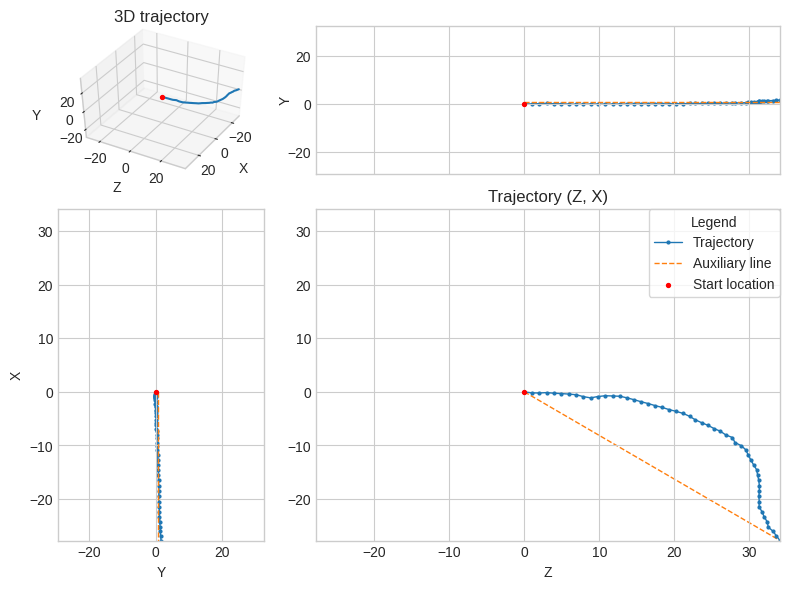

In [39]:

########################################################

# emd
trajectory = estimate_trajectory(estimate_motion, unfiltered_matches, kp_list, K, \
                                 depth_maps=depth_maps,mode='emd')
visualize_trajectory(trajectory)

########################################################


### EMD - filtered

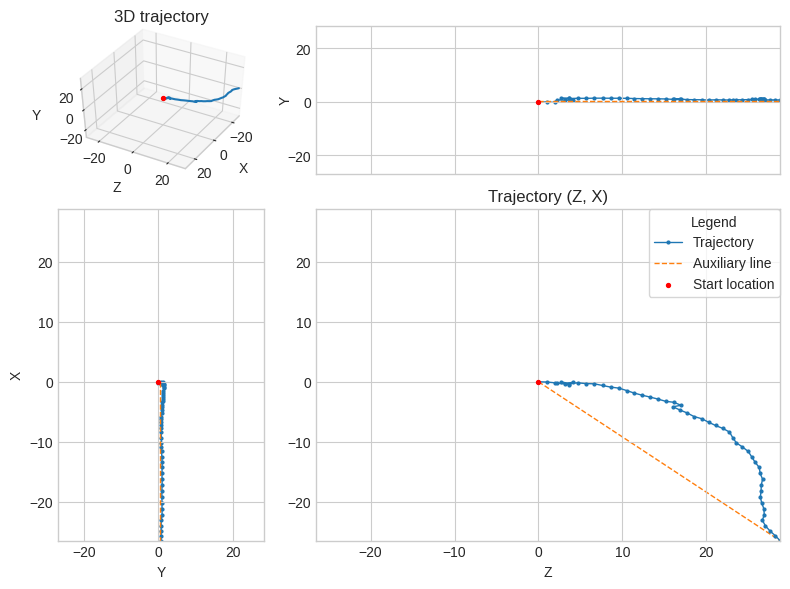

In [40]:
########################################################

# emd
trajectory = estimate_trajectory(estimate_motion, filtered_matches, kp_list, K, \
                                 depth_maps=depth_maps,mode='emd')
visualize_trajectory(trajectory)

########################################################


### PnP - unfiltered

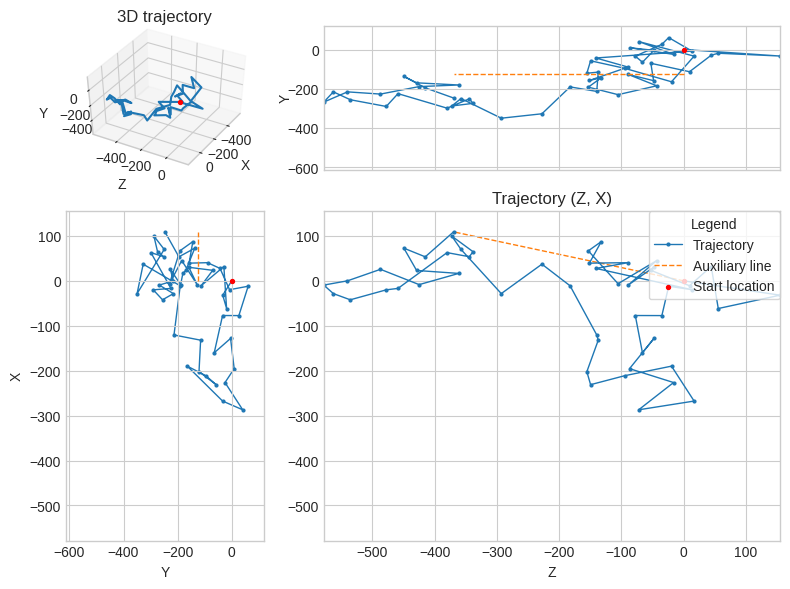

In [41]:
#######################################################

# PNP
trajectory = estimate_trajectory(estimate_motion, unfiltered_matches, kp_list, K, \
                                 depth_maps=depth_maps,mode='pnp')
visualize_trajectory(trajectory)
print()

########################################################


### PnP - filtered

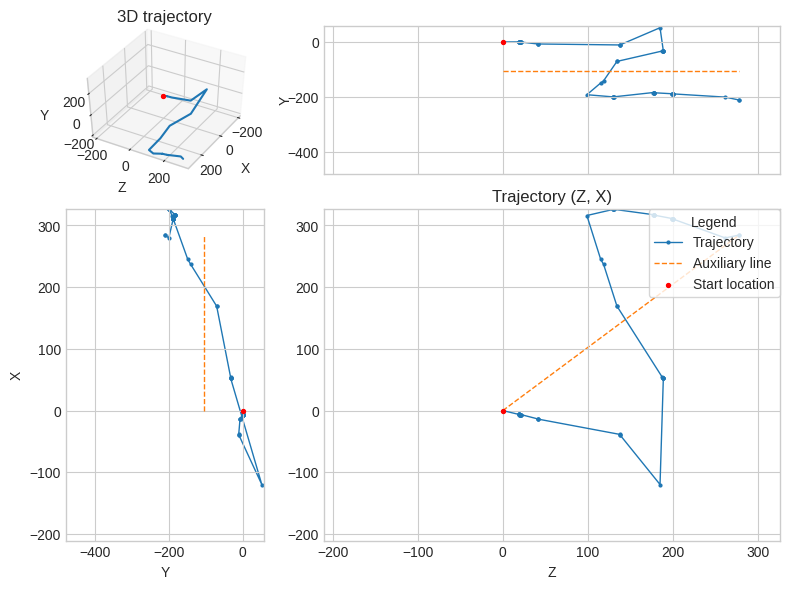

In [42]:
#######################################################

# PNP
trajectory = estimate_trajectory(estimate_motion, filtered_matches, kp_list, K, \
                                 depth_maps=depth_maps,mode='pnp')
visualize_trajectory(trajectory)
print()

########################################################


### PnP RANSAC - unfiltered

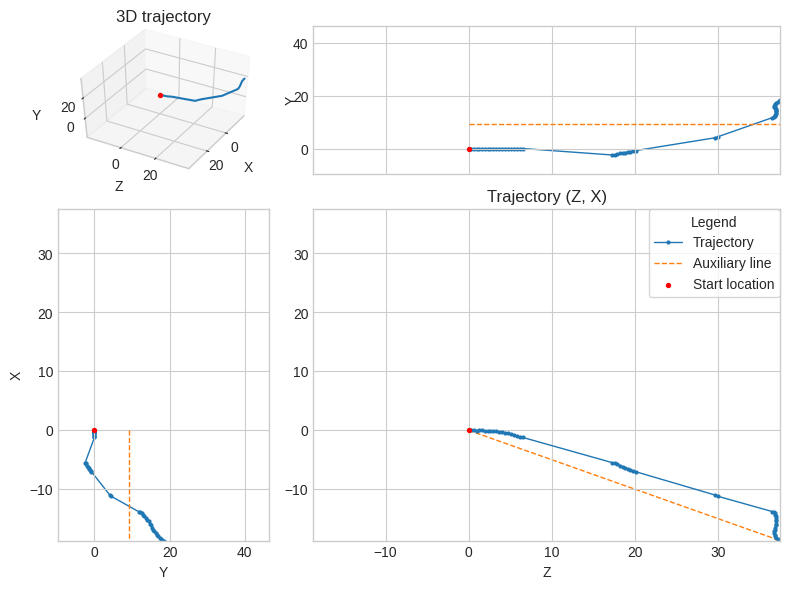

In [43]:
########################################################

#  PNP RANSAC
trajectory = estimate_trajectory(estimate_motion, unfiltered_matches, kp_list, K, \
                                 depth_maps=depth_maps,mode='pnp_ransac')
visualize_trajectory(trajectory)

########################################################


### PnP RANSAC - filtered

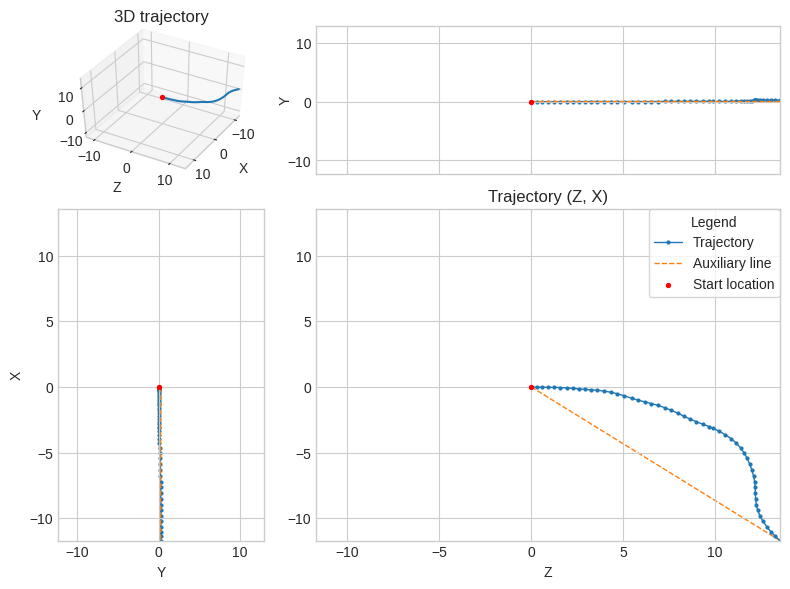

In [44]:
########################################################

#  PNP RANSAC
trajectory = estimate_trajectory(estimate_motion, filtered_matches, kp_list, K, \
                                 depth_maps=depth_maps,mode='pnp_ransac')
visualize_trajectory(trajectory)

########################################################


## 6 - Observations

A comparison can be made of the plotted trajectory results using EMD, PnP, and PnP-RANSAC with both distance filtered and unflitered feature matches between images.

PnP-RANSAC (with filtering) is the best followed by EMD (without filtering). PnP is the worst.

PnP-RANSAC does well with pre-filtered data but cannot handle points from matches that are not distance filtered.
 
EMD has a tendency to drift (like IMU measuements and state estimations over time). The results could possibly be improved with sensor fusion and feedback corrections using measurements from other sensor devices. EKF (Extended Kalman Filter) or ES-EKF (error state EKF) could be explored as a possible technique.

Plain ordinary PnP is more similar to an experiment in a random walk trajectories! Without an adequate filtering mechanism it is not equiped for accurate trajectory estimations given the parameters used generate the input data for this project. Simple distance filtering is not enough. A better outlier filtering algorithm like RANSAC is required.
 